In [2]:
%tensorflow_version 1.x
import tensorflow as tf
#tf.enable_eager_execution()
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy import optimize
import matplotlib.dates as dates
from ipywidgets import interact, widgets
from scipy.integrate import solve_ivp
plt.style.use('seaborn-poster')
matplotlib.rcParams['figure.figsize'] = (10., 6.)
import copy
import sympy
%matplotlib inline
import scipy as sp
from scipy.integrate import odeint
import timeit
import time
import os
from scipy.interpolate import CubicSpline
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
np.set_printoptions(threshold=np.inf)
from prettytable import PrettyTable  
from datetime import datetime
import matplotlib.dates as mdates
import datetime as dt
import matplotlib as mpl

TensorFlow 1.x selected.


(192, 1)


Text(0, 0.5, 'The Population rate')

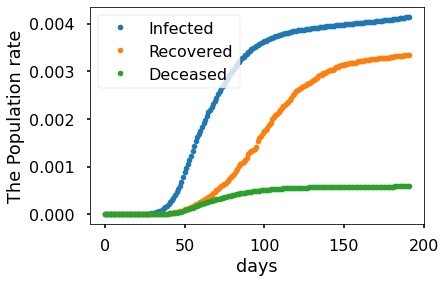

In [3]:
url1 = 'https://raw.githubusercontent.com/Jiel73654/Qualify-Exam_JieLong/master/time_series_covid19_confirmed_global.csv'
re_url = 'https://raw.githubusercontent.com/Jiel73654/Qualify-Exam_JieLong/master/time_series_covid19_recovered_global.csv'
dh_url = 'https://raw.githubusercontent.com/Jiel73654/Qualify-Exam_JieLong/master/time_series_covid19_deaths_global.csv'
Confirmed = pd.read_csv(url1,error_bad_lines=False)
Deaths = pd.read_csv(dh_url,error_bad_lines=False)
Recovered = pd.read_csv(re_url,error_bad_lines=False)
IT_dh = Deaths.loc[(Deaths["Country/Region"] == "Italy") & (Deaths["Province/State"].isnull() == True)]
IT_re = Recovered.loc[(Recovered["Country/Region"] == "Italy") & (Recovered["Province/State"].isnull() == True)]
IT_cf = Confirmed.loc[(Confirmed["Country/Region"] == "Italy") & (Confirmed["Province/State"].isnull() == True)]
length = IT_cf.shape[1]-13
IC = IT_cf.iloc[:,13:].to_numpy().reshape(length,1)
DC = IT_dh.iloc[:,13:].to_numpy().reshape(length,1)
RC = IT_re.iloc[:,13:].to_numpy().reshape(length,1)
T = np.arange(0,length).reshape(length,1)
II = IC - DC - RC
N0 = 60.36*1.e6
SS = N0 - II - RC - DC
print(II.shape)
plt.plot(T,IC/N0,'.')
plt.plot(T,RC/N0,'.')
plt.plot(T,DC/N0,'.')
plt.legend(("Infected","Recovered","Deceased"))
plt.xlabel("days")
plt.ylabel("The Population rate")

In [4]:
IT_cf.iloc[:,13:]

,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,...,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20,8/2/20,8/3/20,8/4/20,8/5/20,8/6/20,8/7/20,8/8/20,8/9/20
137,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,20,62,155,229,322,453,655,888,1128,1694,2036,2502,3089,3858,4636,5883,7375,9172,10149,...,240760,240961,241184,241419,241611,241819,241956,242149,242363,242639,242827,243061,243230,243344,243506,243736,243967,244216,244434,244624,244752,245032,245338,245590,245864,246118,246286,246488,246776,247158,247537,247832,248070,248229,248419,248803,249204,249756,250103,250566


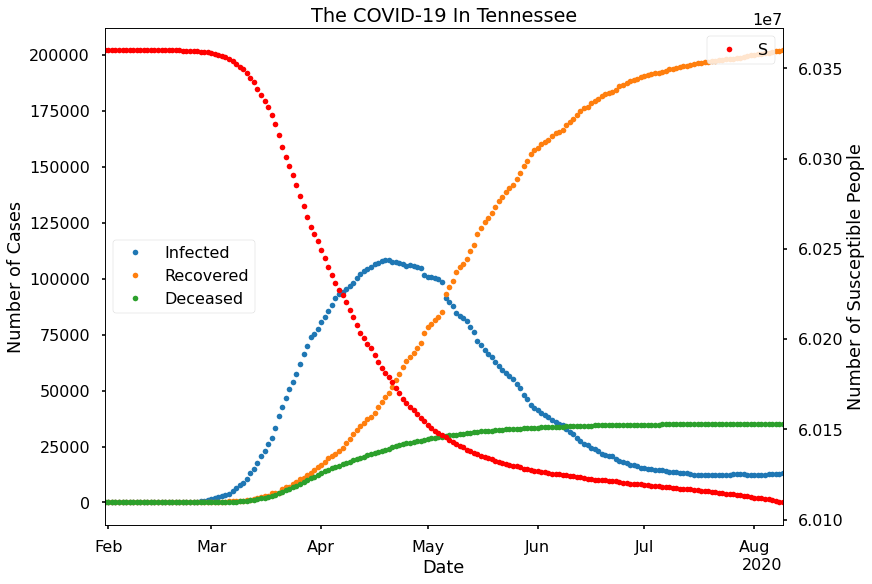

In [5]:
date_begin = dt.datetime(2020,1,31)
date_end = dt.datetime(2020,8,10)
delta = dt.timedelta(days=1)
dates = mpl.dates.drange(date_begin, date_end, delta)
fig, axs = plt.subplots(constrained_layout=True, figsize=(12, 8))
lims = (np.datetime64('2020-01-31'), np.datetime64('2020-08-09'))
locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
axs.xaxis.set_major_locator(locator)
axs.xaxis.set_major_formatter(formatter)
axs.plot(dates, II,'.')
axs.plot(dates, RC,'.')
axs.plot(dates, DC,'.')
axs.set_xlabel("Date")
axs.set_ylabel("Number of Cases")
axs.set_xlim(lims)
axs.legend(("Infected","Recovered","Deceased"),loc = "center left")
ax1 = axs.twinx()
ax1.plot(dates,SS,'.',c = 'red')
ax1.legend("Susceptible")
ax1.set_ylabel("Number of Susceptible People")
axs.set_title('The COVID-19 In Tennessee')
plt.show()

In [18]:
np.random.seed(12345)
tf.compat.v1.set_random_seed(12345)
tf.compat.v1.disable_eager_execution()
class SIRD:
    def __init__(self, I, R, D, S, T, layers):
        self.t = T
        self.I = I
        self.R = R
        self.S = S
        self.D = D
        self.layers = layers
        self.lb = T.min()
        self.ub = T.max()
        # Initialize NN
        self.weights, self.biases = self.initialize_NN(self.layers)
        
        # Initialize parameters
        self.gamma = tf.Variable([1],constraint=lambda x: tf.clip_by_value(x,0,1),dtype=tf.float32)
        self.beta = tf.Variable([1],constraint=lambda x: tf.clip_by_value(x,0,1),dtype=tf.float32)
        self.mu = tf.Variable([1],constraint=lambda x: tf.clip_by_value(x,0,1),dtype=tf.float32)
        # tf placeholders and graph
        self.sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        self.t_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        self.I_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.I.shape[1]])
        self.R_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.R.shape[1]])
        self.S_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.S.shape[1]])
        self.D_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.D.shape[1]])
       
        self.S_pred, self.I_pred, self.R_pred,self.D_pred,self.E1_pred, self.E2_pred, self.E3_pred, self.E4_pred, self.E5_pred = self.net_NS(
            self.t_tf)
        self.GE = tf.reduce_mean(tf.square(self.E1_pred))+ tf.reduce_mean(tf.square(self.E2_pred)) +\
                  tf.reduce_mean(tf.square(self.E3_pred)) + tf.reduce_mean(tf.square(self.E4_pred)) + tf.reduce_mean(tf.square(self.E5_pred))
        self.OB = tf.reduce_mean(tf.square(self.I_tf - self.I_pred)) + tf.reduce_mean(tf.square(self.R_pred - self.R_tf)) +\
                  tf.reduce_mean(tf.square(self.S_tf - self.S_pred)) + tf.reduce_mean(tf.square(self.D_tf - self.D_pred))
        self.loss = self.GE + self.OB
                    
        
        
        self.optimizer_Adam = tf.compat.v1.train.AdamOptimizer()
        #self.optimizer_Adam = tf.compat.v1.train.AdagradOptimizer(learning_rate = 0.01)
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)                                     
        init = tf.compat.v1.global_variables_initializer()
        self.sess.run(init)
         
        
    def initialize_NN(self, layers):
        def xavier_init(size):
            in_dim = size[0]
            out_dim = size[1]        
            xavier_stddev = np.sqrt(2/(in_dim + out_dim))
            return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)        
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0,num_layers-1):
            W = xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
    
    
    
    def forward(self, X, weights, biases):
        num_layers = len(weights) + 1
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.nn.softplus(tf.add(tf.matmul(H, W), b))
        return Y

    def forward1(self, X, weights, biases):
        num_layers = len(weights) + 1
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.nn.sigmoid(tf.add(tf.matmul(H, W), b))
        return Y

    def net_NS(self, t):
        gamma = self.gamma
        beta = self.beta
        mu = self.mu
        output = self.forward1(t, self.weights, self.biases)       
        
        S = output[:,0:1]
        I = output[:,1:2]
        R = output[:,2:3]
        D = output[:,3:4]

        E1 = tf.gradients(S, t)[0] + beta*S*I
        E2 = tf.gradients(I, t)[0] - beta*S*I + (mu + gamma)*I
        E3 = tf.gradients(R, t)[0] - gamma*I
        E4 = tf.gradients(D, t)[0] - mu*I
        E5 = 1 - (S+I+R+D)
        return S,I,R,D,E1,E2,E3,E4,E5

    def callback(self, loss):
        print('Loss: %.3e' % (loss))
    def train(self, nIter): 

        tf_dict = {self.t_tf: self.t, self.I_tf: self.I,self.R_tf: self.R,self.S_tf: self.S,self.D_tf: self.D}
        cpu_time = 0       
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            if it % 10000 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                gamma_value = self.sess.run(self.gamma)
                beta_value = self.sess.run(self.beta)
                mu_value = self.sess.run(self.mu)
                ge_loss = self.sess.run(self.GE, tf_dict)
                ob_loss = self.sess.run(self.OB, tf_dict)
                cpu_time = cpu_time + elapsed
                print('It: %d, Loss: %.3e, GE_loss: %.5e,OB_loss: %.5e, Beta: %.5e,gamma: %.5e,mu: %.5e, Time: %.2f, cumulative_time: %.2f' % 
                      (it, loss_value,ge_loss,ob_loss,beta_value,gamma_value,mu_value,elapsed,cpu_time))
                start_time = time.time()
        return cpu_time
    def predict(self, t_star):
        tf_dict = {self.t_tf: t_star}
        S = self.sess.run(self.S_pred, tf_dict)
        I = self.sess.run(self.I_pred, tf_dict)
        R = self.sess.run(self.R_pred, tf_dict)
        D = self.sess.run(self.D_pred, tf_dict)
        return S,I,R,D

In [24]:
np.random.seed(1234)
tf.compat.v1.set_random_seed(1234)
tf.compat.v1.disable_eager_execution()
class SIRD1:
    def __init__(self, I, R, D, S, T, layers):
        self.t = T
        self.I = I
        self.R = R
        self.S = S
        self.D = D
        self.layers = layers
        self.lb = T.min()
        self.ub = T.max()
        # Initialize NN
        self.weights, self.biases = self.initialize_NN(self.layers)
        
        # Initialize parameters
        self.gamma = tf.Variable([1],dtype=tf.float32)
        self.beta = tf.Variable([1],dtype=tf.float32)
        self.mu = tf.Variable([1],dtype=tf.float32)
        # tf placeholders and graph
        self.sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        self.t_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        self.I_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.I.shape[1]])
        self.R_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.R.shape[1]])
        self.S_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.S.shape[1]])
        self.D_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.D.shape[1]])
       
        self.S_pred, self.I_pred, self.R_pred,self.D_pred,self.E1_pred, self.E2_pred, self.E3_pred, self.E4_pred, self.E5_pred = self.net_NS(
            self.t_tf)
        self.GE = tf.reduce_mean(tf.abs(self.E1_pred))+ tf.reduce_mean(tf.abs(self.E2_pred)) +\
                  tf.reduce_mean(tf.abs(self.E3_pred)) + tf.reduce_mean(tf.abs(self.E4_pred)) + tf.reduce_mean(tf.abs(self.E5_pred))
        self.OB = tf.reduce_mean(tf.abs(self.I_tf - self.I_pred)) + tf.reduce_mean(tf.abs(self.R_pred - self.R_tf)) +\
                  tf.reduce_mean(tf.abs(self.S_tf - self.S_pred)) + tf.reduce_mean(tf.abs(self.D_tf - self.D_pred))
        self.loss = self.GE + self.OB
                    
        
        
        self.optimizer_Adam = tf.compat.v1.train.AdamOptimizer()
        #self.optimizer_Adam = tf.compat.v1.train.AdagradOptimizer(learning_rate = 0.01)
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)                                     
        init = tf.compat.v1.global_variables_initializer()
        self.sess.run(init)
         
        
    def initialize_NN(self, layers):
        def xavier_init(size):
            in_dim = size[0]
            out_dim = size[1]        
            xavier_stddev = np.sqrt(2/(in_dim + out_dim))
            return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)        
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0,num_layers-1):
            W = xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
    
    
    
    def forward(self, X, weights, biases):
        num_layers = len(weights) + 1
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.nn.softplus(tf.add(tf.matmul(H, W), b))
        return Y

    def forward1(self, X, weights, biases):
        num_layers = len(weights) + 1
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.nn.sigmoid(tf.add(tf.matmul(H, W), b))
        return Y

    def net_NS(self, t):
        gamma = self.gamma
        beta = self.beta
        mu = self.mu
        output = self.forward1(t, self.weights, self.biases)       
        
        S = output[:,0:1]
        I = output[:,1:2]
        R = output[:,2:3]
        D = output[:,3:4]

        E1 = tf.gradients(S, t)[0] + beta*S*I
        E2 = tf.gradients(I, t)[0] - beta*S*I + (mu + gamma)*I
        E3 = tf.gradients(R, t)[0] - gamma*I
        E4 = tf.gradients(D, t)[0] - mu*I
        E5 = 1 - (S+I+R+D)
        return S,I,R,D,E1,E2,E3,E4,E5

    def callback(self, loss):
        print('Loss: %.3e' % (loss))
    def train(self, nIter): 

        tf_dict = {self.t_tf: self.t, self.I_tf: self.I,self.R_tf: self.R,self.S_tf: self.S,self.D_tf: self.D}
        cpu_time = 0       
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            if it % 10000 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                gamma_value = self.sess.run(self.gamma)
                beta_value = self.sess.run(self.beta)
                mu_value = self.sess.run(self.mu)
                ge_loss = self.sess.run(self.GE, tf_dict)
                ob_loss = self.sess.run(self.OB, tf_dict)
                cpu_time = cpu_time + elapsed
                print('It: %d, Loss: %.3e, GE_loss: %.5e,OB_loss: %.5e, Beta: %.5e,gamma: %.5e,mu: %.5e, Time: %.2f, cumulative_time: %.2f' % 
                      (it, loss_value,ge_loss,ob_loss,beta_value,gamma_value,mu_value,elapsed,cpu_time))
                start_time = time.time()
        return cpu_time
    def predict(self, t_star):
        tf_dict = {self.t_tf: t_star}
        S = self.sess.run(self.S_pred, tf_dict)
        I = self.sess.run(self.I_pred, tf_dict)
        R = self.sess.run(self.R_pred, tf_dict)
        D = self.sess.run(self.D_pred, tf_dict)
        return S,I,R,D

In [20]:
def handle(t1,t2,T_test,neural_network,s,i,r,d,layers,N_iter,N0,iter_num,S_ode,I_ode,R_ode,D_ode,S_learned,I_learned,R_learned,D_learned):
    a = CubicSpline(T_test,s[t1:t2])
    b = CubicSpline(T_test,i[t1:t2])
    c = CubicSpline(T_test,r[t1:t2])
    dd = CubicSpline(T_test,d[t1:t2])
    t_train = np.arange(t1,t2 - 1+iter_num,iter_num)
    s_train = a(t_train).reshape(len(t_train),1)/N0
    i_train = b(t_train).reshape(len(t_train),1)/N0
    r_train = c(t_train).reshape(len(t_train),1)/N0
    d_train = dd(t_train).reshape(len(t_train),1)/N0
    TT_train = t_train.reshape(len(t_train),1)
    model = neural_network(i_train,r_train,d_train,s_train,TT_train,layers)
    CPU_time = model.train(N_iter)
    TT = T_test.reshape(len(T_test),1)
    S_out,I_out,R_out,D_out = model.predict(TT)
    beta = model.sess.run(model.beta)
    gamma = model.sess.run(model.gamma)
    mu = model.sess.run(model.mu)
    print("beta: ",beta)
    print("gamma: ",gamma)
    print("mu: ",mu)
    def sird_model(z,t,beta_value,gamma,mu):
        s1 = z[0]
        i1 = z[1]
        r1 = z[2]
        d1 = z[3]
        dsdt = -beta_value*i1*s1
        didt = beta_value*i1*s1 - (gamma+mu)*i1
        drdt = gamma*i1
        dddt = mu*i1
        dzdt = [dsdt,didt,drdt,dddt]
        return dzdt
    z0 = [s_train[0,0],i_train[0,0],r_train[0,0],d_train[0,0]]
    z_sol = odeint(sird_model,z0,T_test,args=(beta[0],gamma[0],mu[0]))
    plt.figure(figsize=(8,14), dpi=100)
    plt.figure(1)
    plt.subplots_adjust(hspace = 0.5)
    ax1 = plt.subplot(411)  
    plt.plot(TT,100*S_out,c="red")
    plt.plot(T_test,100*z_sol[:,0],c='black')
    plt.scatter(T_test,100*s[t1:t2]/N0,marker='o',c='',edgecolors='blue',s=40,linewidths=1)
    plt.xlabel("Time(days)")
    plt.ylabel("S/N(%)")
    plt.legend(("S_nn","S_ode","S_data"))
    ax1 = plt.subplot(412) 
    plt.plot(TT,100*I_out,c="red")
    plt.plot(T_test,100*z_sol[:,1],c = "black")
    plt.scatter(T_test,100*i[t1:t2]/N0,marker='o',c='',edgecolors='blue',s=40,linewidths=1)
    plt.xlabel("Time(days)")
    plt.ylabel("I/N(%)")
    plt.legend(("I_nn","I_ode","I_data"))
    ax1 = plt.subplot(413)
    plt.plot(TT,100*R_out,c="red")
    plt.plot(T_test,100*z_sol[:,2],c = 'black')
    plt.scatter(T_test,100*r[t1:t2]/N0,marker='o',c='',edgecolors='blue',s=40,linewidths=1)
    plt.xlabel("Time(days)")
    plt.ylabel("R/N(%)")
    plt.legend(("R_nn","R_ode","R_data"))
    ax1 = plt.subplot(414)
    plt.plot(TT,100*D_out,c="red")
    plt.plot(T_test,100*z_sol[:,3],c='black')
    plt.scatter(T_test,100*d[t1:t2]/N0,marker='o',c='',edgecolors='blue',s=40,linewidths=1)
    plt.legend(("D_nn","D_ode","D_data"))
    plt.xlabel("Time(days)")
    plt.ylabel("D/N(%)")
    plt.show()
    S_ode[t1:t2] = z_sol[:,0]
    I_ode[t1:t2] = z_sol[:,1]
    R_ode[t1:t2] = z_sol[:,2]
    D_ode[t1:t2] = z_sol[:,3]
    S_learned[t1:t2] = S_out[:,0]
    I_learned[t1:t2] = I_out[:,0]
    R_learned[t1:t2] = R_out[:,0]
    D_learned[t1:t2] = D_out[:,0]
    '''
    S_erode = np.abs(s[t1:t2] - S_out)/s[t1:t2]
    S_erNN = np.abs(s[t1:t2] - z_sol[:,0])/s[t1:t2]
    I_erode = np.abs(i[t1:t2] - I_out)/i[t1:t2]
    I_erNN = np.abs(i[t1:t2] - z_sol[:,1])/i[t1:t2]
    R_erode = np.abs(r[t1:t2] - R_out)/r[t1:t2]
    R_erNN = np.abs(r[t1:t2] - z_sol[:,2])/r[t1:t2]
    '''
    return S_out,I_out,R_out,D_out,beta[0],gamma[0],mu[0],z_sol,S_ode,I_ode,R_ode,D_ode,S_learned,I_learned,R_learned,D_learned,CPU_time

In [28]:
def sum_all(layers,length,SS,II,RC,DC,N0,inter_numb,NIter):
    S_ode = np.zeros(length)
    I_ode = np.zeros(length)
    R_ode = np.zeros(length)
    D_ode = np.zeros(length)
    S_learned = np.zeros(length)
    I_learned = np.zeros(length)
    R_learned = np.zeros(length)
    D_learned = np.zeros(length)
    gamma_all = np.zeros(10)
    beta_all = np.zeros(10)
    mu_all = np.zeros(10)
    T1 = np.arange(0,35).reshape(35,)
    S1,I1,R1,D1,beta1,gamma1,mu1,z1,S_ode,I_ode,R_ode,D_ode,S_learned,I_learned,R_learned,D_learned,time1 = handle(0,35,T1,SIRD1,SS,II,RC,DC,layers,NIter,N0,inter_numb,S_ode,I_ode,R_ode,D_ode,S_learned,I_learned,R_learned,D_learned)
    #4th week
    T2 = np.arange(35,42).reshape(7,)
    S2,I2,R2,D2,beta2,gamma2,mu2,z2,S_ode,I_ode,R_ode,D_ode,S_learned,I_learned,R_learned,D_learned,time2 = handle(35,42,T2,SIRD,SS,II,RC,DC,layers,NIter,N0,inter_numb,S_ode,I_ode,R_ode,D_ode,S_learned,I_learned,R_learned,D_learned)
    #5th week
    T3 = np.arange(42,49).reshape(7,)
    S3,I3,R3,D3,beta3,gamma3,mu3,z3,S_ode,I_ode,R_ode,D_ode,S_learned,I_learned,R_learned,D_learned,time3 = handle(42,49,T3,SIRD,SS,II,RC,DC,layers,NIter,N0,inter_numb,S_ode,I_ode,R_ode,D_ode,S_learned,I_learned,R_learned,D_learned)
    #6th week
    T4 = np.arange(49,56).reshape(7,)
    S4,I4,R4,D4,beta4,gamma4,mu4,z4,S_ode,I_ode,R_ode,D_ode,S_learned,I_learned,R_learned,D_learned,time4 = handle(49,56,T4,SIRD,SS,II,RC,DC,layers,NIter,N0,inter_numb,S_ode,I_ode,R_ode,D_ode,S_learned,I_learned,R_learned,D_learned)
    #7th week
    T5 = np.arange(56,63).reshape(7,)
    S5,I5,R5,D5,beta5,gamma5,mu5,z5,S_ode,I_ode,R_ode,D_ode,S_learned,I_learned,R_learned,D_learned,time5 = handle(56,63,T5,SIRD,SS,II,RC,DC,layers,NIter,N0,inter_numb,S_ode,I_ode,R_ode,D_ode,S_learned,I_learned,R_learned,D_learned)
    #8th week
    T6 = np.arange(63,70).reshape(7,)
    S6,I6,R6,D6,beta6,gamma6,mu6,z6,S_ode,I_ode,R_ode,D_ode,S_learned,I_learned,R_learned,D_learned,time6 = handle(63,70,T6,SIRD,SS,II,RC,DC,layers,NIter,N0,inter_numb,S_ode,I_ode,R_ode,D_ode,S_learned,I_learned,R_learned,D_learned)
    #9th week
    T7 = np.arange(70,77).reshape(7,)
    S7,I7,R7,D7,beta7,gamma7,mu7,z7,S_ode,I_ode,R_ode,D_ode,S_learned,I_learned,R_learned,D_learned,time7 = handle(70,77,T7,SIRD,SS,II,RC,DC,layers,NIter,N0,inter_numb,S_ode,I_ode,R_ode,D_ode,S_learned,I_learned,R_learned,D_learned)
    #10th week
    T8 = np.arange(77,84).reshape(7,)
    S8,I8,R8,D8,beta8,gamma8,mu8,z8,S_ode,I_ode,R_ode,D_ode,S_learned,I_learned,R_learned,D_learned,time8 = handle(77,84,T8,SIRD,SS,II,RC,DC,layers,NIter,N0,inter_numb,S_ode,I_ode,R_ode,D_ode,S_learned,I_learned,R_learned,D_learned)
    #11th week
    T9 = np.arange(84,91).reshape(7,)
    S9,I9,R9,D9,beta9,gamma9,mu9,z9,S_ode,I_ode,R_ode,D_ode,S_learned,I_learned,R_learned,D_learned,time9 = handle(84,91,T9,SIRD,SS,II,RC,DC,layers,NIter,N0,inter_numb,S_ode,I_ode,R_ode,D_ode,S_learned,I_learned,R_learned,D_learned)
    #left weeks
    T10 = np.arange(91,length).reshape(length - 91,)
    S10,I10,R10,D10,beta10,gamma10,mu10,z10,S_ode,I_ode,R_ode,D_ode,S_learned,I_learned,R_learned,D_learned,time10 = handle(91,length,T10,SIRD,SS,II,RC,DC,layers,NIter,N0,inter_numb,S_ode,I_ode,R_ode,D_ode,S_learned,I_learned,R_learned,D_learned)
    gamma_all[0],gamma_all[1],gamma_all[2],gamma_all[3],gamma_all[4] = gamma1,gamma2,gamma3,gamma4,gamma5
    gamma_all[5],gamma_all[6],gamma_all[7],gamma_all[8],gamma_all[9] = gamma6,gamma7,gamma8,gamma9,gamma10
    beta_all[0],beta_all[1],beta_all[2],beta_all[3],beta_all[4] = beta1,beta2,beta3,beta4,beta5
    beta_all[5],beta_all[6],beta_all[7],beta_all[8],beta_all[9] = beta6,beta7,beta8,beta9,beta10
    mu_all[0],mu_all[1],mu_all[2],mu_all[3],mu_all[4],mu_all[5],mu_all[6],mu_all[7],mu_all[8],mu_all[9] = mu1,mu2,mu3,mu4,mu5,mu6,mu7,mu8,mu9,mu10
    time_con = time1+time2+time3+time4+time5+time6+time7+time8+time9+time10
    date_begin = dt.datetime(2020,1,31)
    date_end = dt.datetime(2020,8,10)
    delta = dt.timedelta(days=1)
    dates = mpl.dates.drange(date_begin, date_end, delta)
    lims = (np.datetime64('2020-01-31'), np.datetime64('2020-08-10'))
    fig, axs = plt.subplots(4, 1, constrained_layout=True, figsize=(13, 15))
    y = np.array([SS/N0,II/N0,RC/N0,DC/N0])
    y1 = np.array([S_learned,I_learned,R_learned,D_learned])
    y2 = np.array([S_ode,I_ode,R_ode,D_ode])
    y_label1 = ["S/N","I/N","R/N","D/N"]
    legend1 = [("S_data","S_NN","S_ode"),("I_data","I_NN","I_ode"),("R_data","R_NN","R_ode"),("D_data","D_NN","D_ode")]
    title1 = ["Suscceptible","Infected","Recovered","Deceased"]
    for nn, ax in enumerate(axs):
        locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
        formatter = mdates.ConciseDateFormatter(locator)
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)
        ax.plot(dates, y[nn],'.',c='red')
        ax.plot(dates, y1[nn])
        ax.plot(dates, y2[nn])
        ax.set_xlabel("Date")
        ax.set_ylabel(y_label1[nn])
        ax.set_xlim(lims)
        ax.set_title(title1[nn])
        ax.legend(legend1[nn])
    plt.show()
    x = PrettyTable()
    x.field_names = ["Paramaters","01/31-03/05","03/06-03/12","03/13-03/19","03/20-03/26","03/27-04/02","04/03-04/09","04/10-04/16" ,"04/17-04/23","04/24-04/30","05/02-08/09"]
    x.add_row(["beta",round(beta1,4),round(beta2,4),round(beta3,4),round(beta4,4),round(beta5,4),round(beta6,4),round(beta7,4),round(beta8,4),round(beta9,4),round(beta10,4)])
    x.add_row(["gamma",round(gamma1,4),round(gamma2,4),round(gamma3,4),round(gamma4,4),round(gamma5,4),round(gamma6,4),round(gamma7,4),round(gamma8,4),round(gamma9,4),round(gamma10,4)])
    x.add_row(["mu",round(mu1,4),round(mu2,4),round(mu3,4),round(mu4,4),round(mu5,4),round(mu6,4),round(mu7,4),round(mu8,4),round(mu9,4),round(mu10,4)])
    x.add_row(["Reproduction Number",round(beta1/(mu1+gamma1),4),round(beta2/(mu2+gamma2),4),round(beta3/(mu3+gamma3),4),round(beta4/(mu4+gamma4),4),round(beta5/(mu5+gamma5),4),round(beta6/(mu6+gamma6),4),round(beta7/(mu7+gamma7),4),round(beta8/(mu8+gamma8),4),round(beta9/(mu9+gamma9),4),round(beta10/(mu10+gamma10),4)])
    print(x)
    R0 = beta_all/(mu_all+gamma_all)
    S_erNN = np.abs(S_learned[35:].reshape(len(S_learned) - 35,1) -SS[35:]/N0)/(SS[35:]/N0)
    S_erode = np.abs(S_ode[35:].reshape(len(S_ode) - 35,1) -SS[35:]/N0)/(SS[35:]/N0)
    I_erNN = np.abs(I_learned[35:].reshape(len(I_learned) - 35,1) - II[35:]/N0)/(II[35:]/N0)
    I_erode = np.abs(I_ode[35:].reshape(len(I_ode) - 35,1) - II[35:]/N0)/(II[35:]/N0)
    date_begin1 = dt.datetime(2020,3,6)
    delta = dt.timedelta(days=1)
    dates1 = mpl.dates.drange(date_begin1, date_end, delta)
    lims1 = (np.datetime64('2020-03-06'), np.datetime64('2020-08-10'))
    R_erNN = np.abs((R_learned[35:].reshape(len(R_learned)-35,1)) - (RC[35:,:]/N0))/(RC[35:,:]/N0)
    R_erode = np.abs(R_ode[35:].reshape(len(R_ode)-35,1) - RC[35:,:]/N0)/(RC[35:,:]/N0)
    D_erNN = np.abs(D_learned[35:].reshape(len(D_learned)-35,1) - DC[35:,:]/N0)/(DC[35:,:]/N0)
    D_erode = np.abs(D_ode[35:].reshape(len(D_ode)-35,1) - DC[35:,:]/N0)/(DC[35:,:]/N0)
    fig, axs = plt.subplots(4, 1, constrained_layout=True, figsize=(13, 15))
    nn_err = np.array([S_erNN,I_erNN,R_erNN,D_erNN])
    ode_err = np.array([S_erode,I_erode,R_erode,D_erode])
    for nn, ax in enumerate(axs):
        locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
        formatter = mdates.ConciseDateFormatter(locator)
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)
        ax.plot(dates1, ode_err[nn])
        ax.plot(dates1, nn_err[nn])
        ax.set_xlabel("Date")
        ax.set_ylabel('Relative error')
        ax.set_xlim(lims1)
        ax.legend(("ODE Error","NN Error"))
        ax.set_title(title1[nn])
    plt.show()  
    return S_ode,I_ode,R_ode,D_ode,S_learned,I_learned,R_learned,D_learned,beta_all,gamma_all,mu_all,S_erNN,I_erNN,R_erNN,D_erNN,S_erode,I_erode,R_erode,D_erode,time_con

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

It: 0, Loss: 4.968e+00, GE_loss: 2.97729e+00,OB_loss: 1.99118e+00, Beta: 1.00000e+00,gamma: 9.99000e-01,mu: 9.99000e-01, Time: 3.11, cumulative_time: 3.11
It: 10000, Loss: 2.155e-05, GE_loss: 2.21364e-06,OB_loss: 1.93392e-05, Beta: 1.00000e+00,gamma: 9.40320e-01,mu: 9.40320e-01, Time: 40.68, cumulative_time: 43.79
It: 20000, Loss: 1.138e-05, GE_loss: 1.96399e-07,OB_loss: 1.11852e-05, Beta: 1.79986e+00,gamma: 6.85563e-01,mu: 6.76347e-01, Time: 40.29, cumulative_time: 84.07
It: 30000, Loss: 1.087e-06, GE_loss: 5.06893e-07,OB_loss: 5.79828e-07, Beta: 2.60686e-01,gamma: 2.91890e-02,mu: 1.09489e-02, Time: 40.27, cumulative_time: 124.34
It: 40000, Loss: 1.058e-06, GE_loss: 5.51421e-07,OB_loss: 5.06145e-07, Beta: 2.57385e-01,gamma: 2.91596e-02,mu: 1.07458e-02, Time: 40.69, cumulative_time: 165.03
beta:  [0.25661835]
gamma:  [0.02897034]
mu:  [0.01073039]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


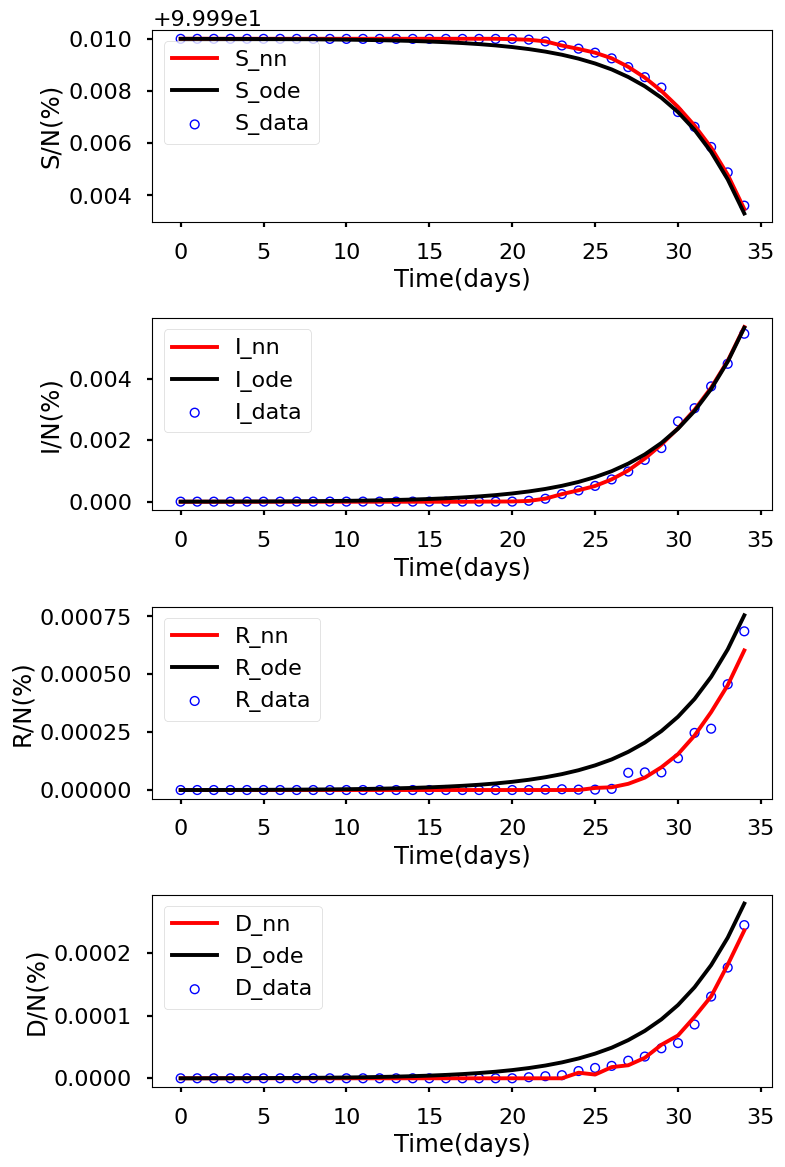

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

It: 0, Loss: 3.039e+00, GE_loss: 2.04328e+00,OB_loss: 9.95828e-01, Beta: 1.00000e+00,gamma: 9.99000e-01,mu: 9.99000e-01, Time: 3.17, cumulative_time: 3.17
It: 10000, Loss: 5.896e-07, GE_loss: 1.79586e-07,OB_loss: 4.10005e-07, Beta: 1.00000e+00,gamma: 9.61868e-01,mu: 9.61972e-01, Time: 32.33, cumulative_time: 35.50
It: 20000, Loss: 1.858e-08, GE_loss: 4.38782e-09,OB_loss: 1.41921e-08, Beta: 1.00000e+00,gamma: 9.59146e-01,mu: 9.59244e-01, Time: 37.71, cumulative_time: 73.22
It: 30000, Loss: 1.115e-08, GE_loss: 4.43259e-09,OB_loss: 6.71912e-09, Beta: 1.00000e+00,gamma: 6.51172e-01,mu: 6.45105e-01, Time: 34.08, cumulative_time: 107.29
It: 40000, Loss: 8.674e-11, GE_loss: 1.44677e-11,OB_loss: 7.22760e-11, Beta: 2.08952e-01,gamma: 2.35133e-02,mu: 1.77258e-02, Time: 31.28, cumulative_time: 138.57
beta:  [0.21427768]
gamma:  [0.02277451]
mu:  [0.0170343]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


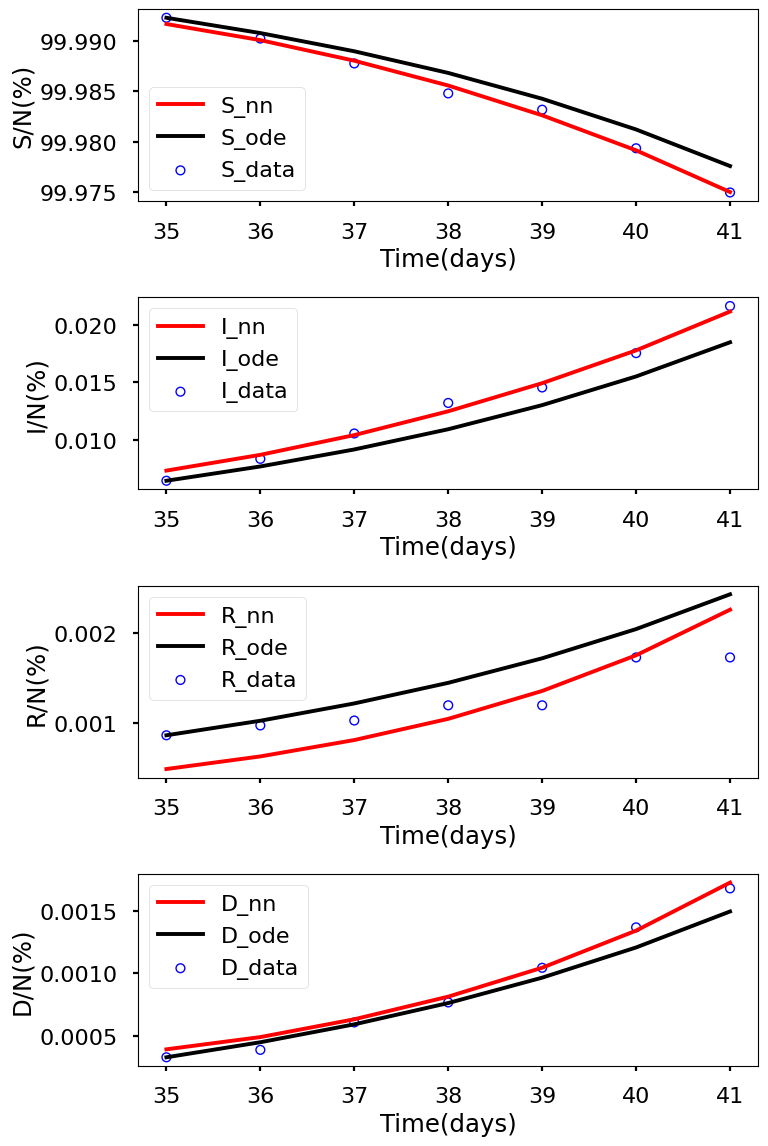

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

It: 0, Loss: 3.055e+00, GE_loss: 2.06032e+00,OB_loss: 9.94906e-01, Beta: 1.00000e+00,gamma: 9.99000e-01,mu: 9.99000e-01, Time: 3.25, cumulative_time: 3.25
It: 10000, Loss: 7.842e-07, GE_loss: 2.21213e-07,OB_loss: 5.63004e-07, Beta: 1.00000e+00,gamma: 9.64301e-01,mu: 9.64289e-01, Time: 36.07, cumulative_time: 39.32
It: 20000, Loss: 1.410e-07, GE_loss: 4.16434e-08,OB_loss: 9.93900e-08, Beta: 1.00000e+00,gamma: 9.49664e-01,mu: 9.49385e-01, Time: 41.18, cumulative_time: 80.50
It: 30000, Loss: 2.359e-10, GE_loss: 5.76128e-11,OB_loss: 1.78280e-10, Beta: 1.55793e-01,gamma: 2.55682e-02,mu: 1.89301e-02, Time: 35.38, cumulative_time: 115.88
It: 40000, Loss: 5.751e-11, GE_loss: 8.95506e-12,OB_loss: 4.85510e-11, Beta: 1.60759e-01,gamma: 2.26146e-02,mu: 1.67601e-02, Time: 35.79, cumulative_time: 151.67
beta:  [0.16122988]
gamma:  [0.022195]
mu:  [0.01635955]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


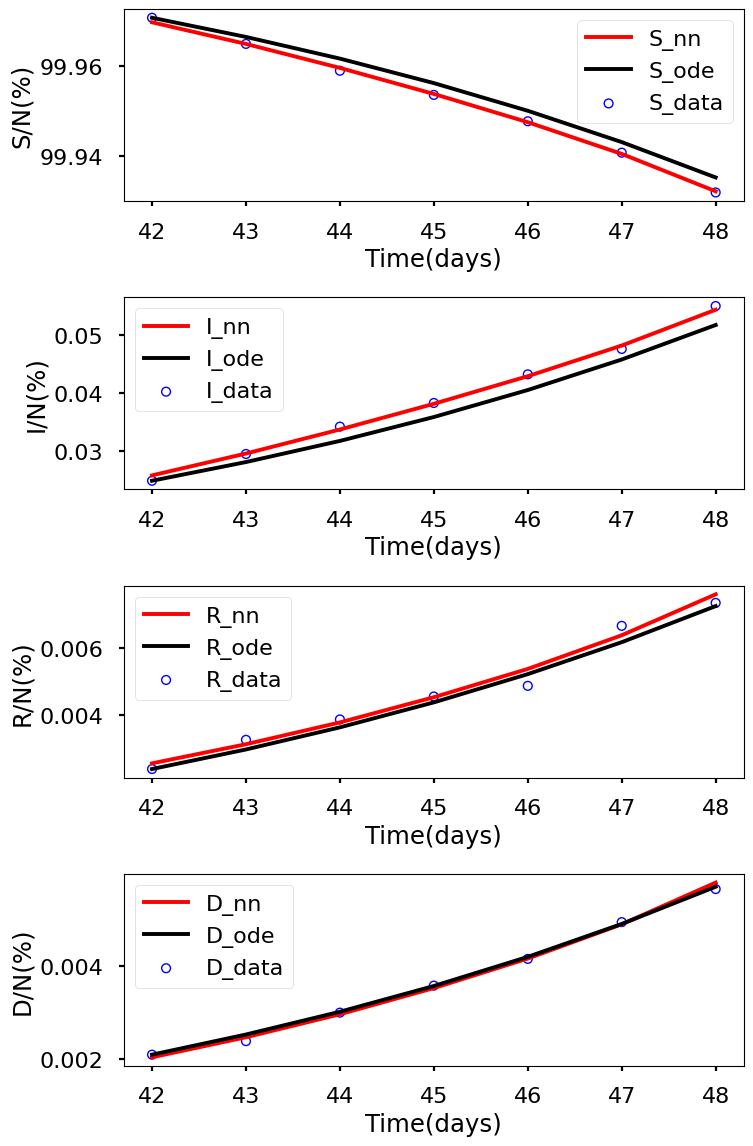

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

It: 0, Loss: 3.093e+00, GE_loss: 2.09769e+00,OB_loss: 9.95704e-01, Beta: 1.00000e+00,gamma: 9.99000e-01,mu: 9.99000e-01, Time: 3.32, cumulative_time: 3.32
It: 10000, Loss: 9.090e-07, GE_loss: 3.69186e-07,OB_loss: 5.39793e-07, Beta: 1.00000e+00,gamma: 9.57337e-01,mu: 9.56891e-01, Time: 35.75, cumulative_time: 39.07
It: 20000, Loss: 5.834e-07, GE_loss: 1.82191e-07,OB_loss: 4.01250e-07, Beta: 1.00000e+00,gamma: 8.98069e-01,mu: 8.95520e-01, Time: 34.88, cumulative_time: 73.95
It: 30000, Loss: 2.355e-10, GE_loss: 6.57931e-11,OB_loss: 1.69661e-10, Beta: 1.07386e-01,gamma: 1.54292e-02,mu: 1.81605e-02, Time: 35.86, cumulative_time: 109.81
It: 40000, Loss: 1.719e-10, GE_loss: 5.25650e-11,OB_loss: 1.19371e-10, Beta: 1.06364e-01,gamma: 1.70682e-02,mu: 1.50418e-02, Time: 35.28, cumulative_time: 145.09
beta:  [0.10618603]
gamma:  [0.01758523]
mu:  [0.01418827]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


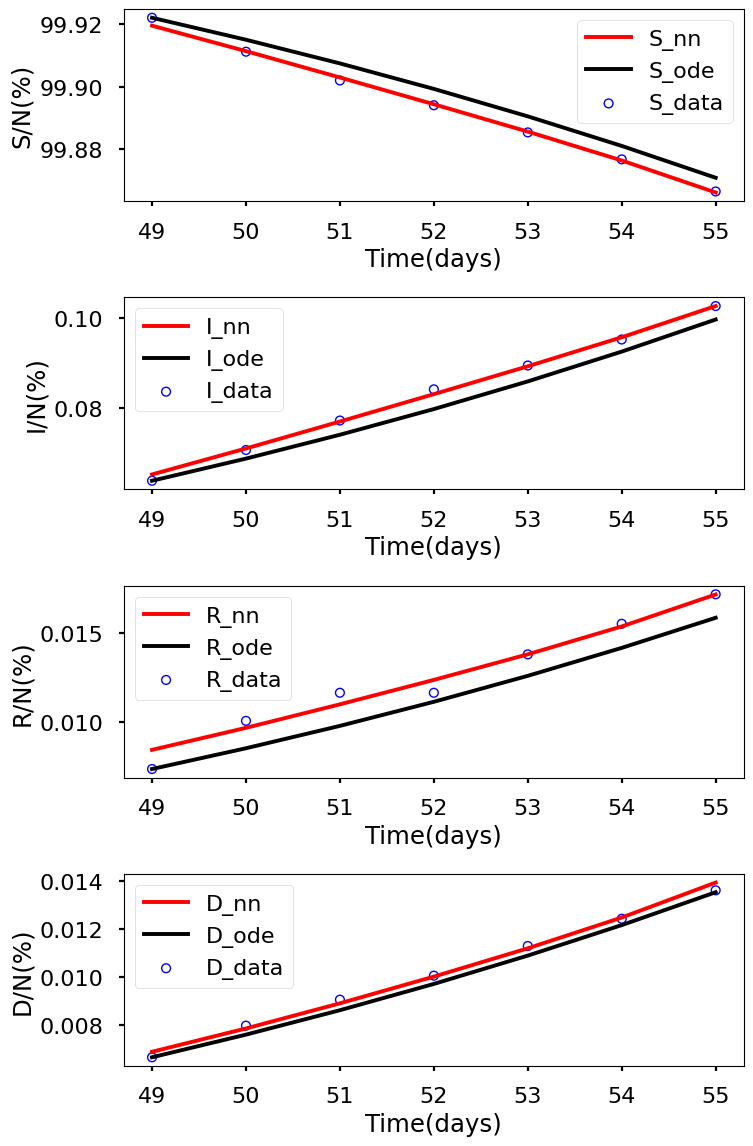

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

It: 0, Loss: 3.056e+00, GE_loss: 2.06334e+00,OB_loss: 9.92188e-01, Beta: 1.00000e+00,gamma: 9.99000e-01,mu: 9.99000e-01, Time: 3.41, cumulative_time: 3.41
It: 10000, Loss: 1.467e-06, GE_loss: 5.41043e-07,OB_loss: 9.25959e-07, Beta: 1.00000e+00,gamma: 9.58064e-01,mu: 9.58326e-01, Time: 31.47, cumulative_time: 34.89
It: 20000, Loss: 1.193e-06, GE_loss: 4.10181e-07,OB_loss: 7.83191e-07, Beta: 1.00000e+00,gamma: 8.11350e-01,mu: 8.11794e-01, Time: 34.33, cumulative_time: 69.22
It: 30000, Loss: 1.685e-10, GE_loss: 3.99783e-11,OB_loss: 1.28528e-10, Beta: 6.16278e-02,gamma: 1.53390e-02,mu: 1.10992e-02, Time: 31.60, cumulative_time: 100.82
It: 40000, Loss: 1.655e-10, GE_loss: 3.99661e-11,OB_loss: 1.25504e-10, Beta: 6.15902e-02,gamma: 1.57014e-02,mu: 1.06255e-02, Time: 32.33, cumulative_time: 133.15
beta:  [0.0615789]
gamma:  [0.01571255]
mu:  [0.01058843]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


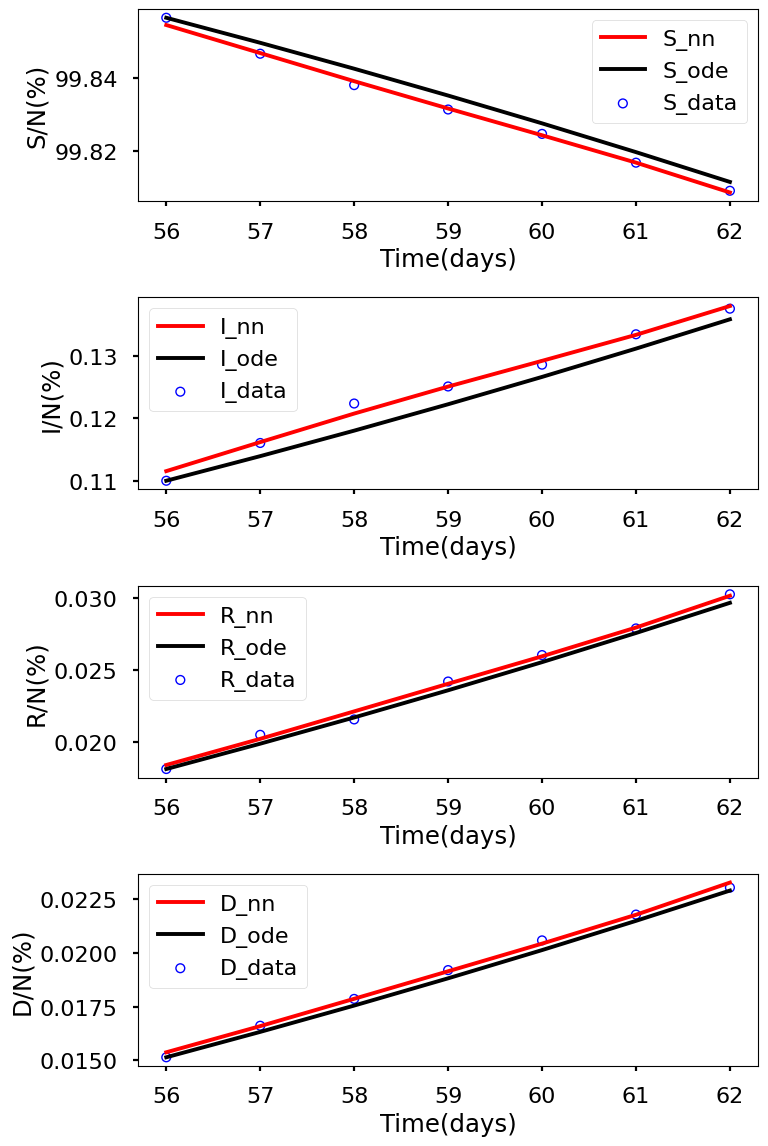

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

It: 0, Loss: 3.024e+00, GE_loss: 2.03028e+00,OB_loss: 9.93968e-01, Beta: 1.00000e+00,gamma: 9.99000e-01,mu: 9.99000e-01, Time: 3.44, cumulative_time: 3.44
It: 10000, Loss: 2.155e-06, GE_loss: 5.72043e-07,OB_loss: 1.58250e-06, Beta: 1.00000e+00,gamma: 9.64459e-01,mu: 9.64548e-01, Time: 38.59, cumulative_time: 42.03
It: 20000, Loss: 1.622e-06, GE_loss: 6.19426e-07,OB_loss: 1.00218e-06, Beta: 9.62276e-01,gamma: 7.18765e-01,mu: 7.11013e-01, Time: 34.60, cumulative_time: 76.63
It: 30000, Loss: 1.813e-10, GE_loss: 6.60903e-11,OB_loss: 1.15233e-10, Beta: 4.16996e-02,gamma: 1.55135e-02,mu: 6.63426e-03, Time: 34.58, cumulative_time: 111.21
It: 40000, Loss: 1.782e-10, GE_loss: 6.12185e-11,OB_loss: 1.17006e-10, Beta: 4.14711e-02,gamma: 1.54254e-02,mu: 6.59373e-03, Time: 32.02, cumulative_time: 143.24
beta:  [0.04147584]
gamma:  [0.01537471]
mu:  [0.0066191]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


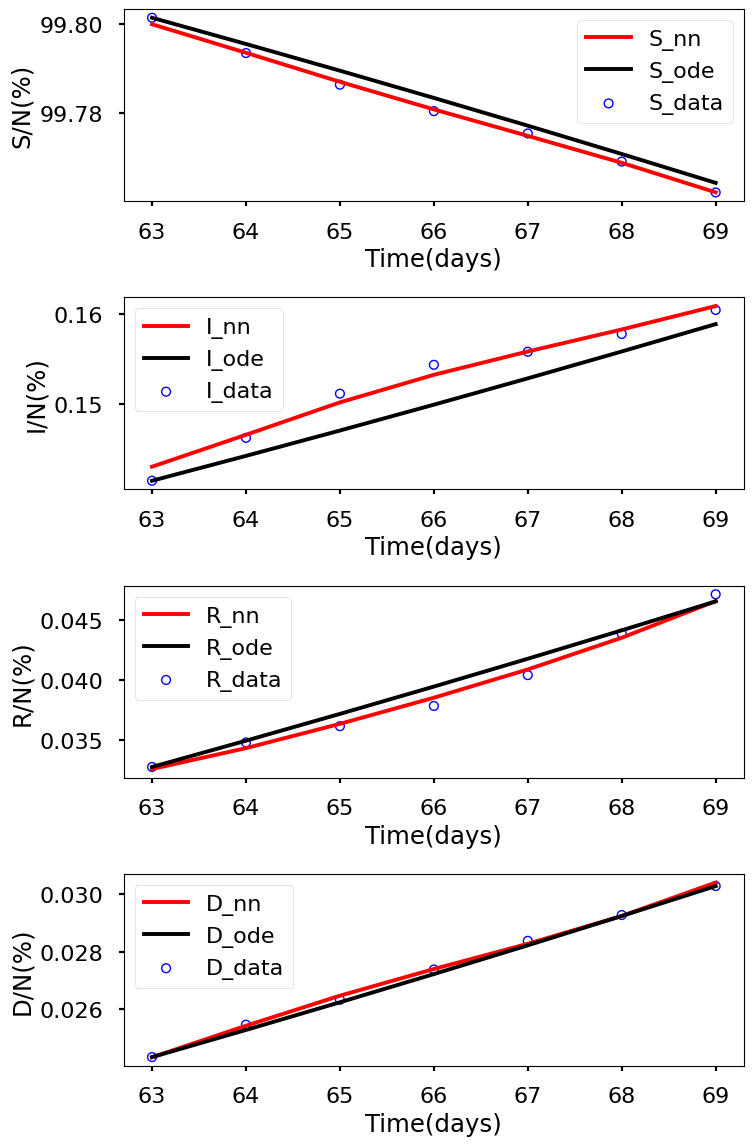

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

It: 0, Loss: 3.052e+00, GE_loss: 2.06370e+00,OB_loss: 9.88477e-01, Beta: 1.00000e+00,gamma: 9.99000e-01,mu: 9.99000e-01, Time: 3.55, cumulative_time: 3.55
It: 10000, Loss: 2.612e-06, GE_loss: 7.17597e-07,OB_loss: 1.89408e-06, Beta: 1.00000e+00,gamma: 9.62239e-01,mu: 9.62374e-01, Time: 33.46, cumulative_time: 37.01
It: 20000, Loss: 1.892e-06, GE_loss: 7.70558e-07,OB_loss: 1.12161e-06, Beta: 9.03190e-01,gamma: 6.62398e-01,mu: 6.57751e-01, Time: 32.57, cumulative_time: 69.58
It: 30000, Loss: 1.276e-10, GE_loss: 5.03377e-11,OB_loss: 7.72269e-11, Beta: 3.30988e-02,gamma: 1.45371e-02,mu: 5.34266e-03, Time: 33.14, cumulative_time: 102.72
It: 40000, Loss: 1.121e-10, GE_loss: 3.50537e-11,OB_loss: 7.70898e-11, Beta: 3.28824e-02,gamma: 1.44765e-02,mu: 5.39648e-03, Time: 34.51, cumulative_time: 137.23
beta:  [0.03287255]
gamma:  [0.01448543]
mu:  [0.00542455]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


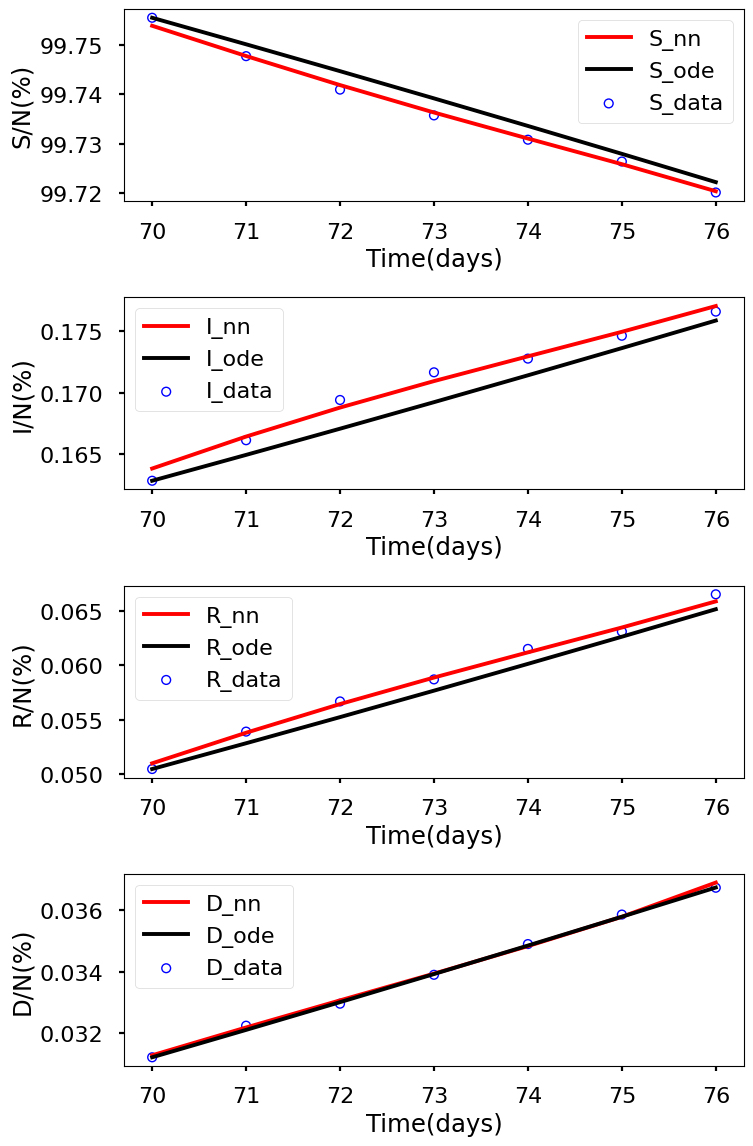

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

It: 0, Loss: 3.056e+00, GE_loss: 2.06656e+00,OB_loss: 9.89792e-01, Beta: 1.00000e+00,gamma: 9.99000e-01,mu: 9.99000e-01, Time: 3.51, cumulative_time: 3.51
It: 10000, Loss: 2.881e-06, GE_loss: 8.27011e-07,OB_loss: 2.05385e-06, Beta: 1.00000e+00,gamma: 9.62154e-01,mu: 9.61846e-01, Time: 31.61, cumulative_time: 35.12
It: 20000, Loss: 1.832e-06, GE_loss: 7.83514e-07,OB_loss: 1.04840e-06, Beta: 8.45330e-01,gamma: 6.36149e-01,mu: 6.20821e-01, Time: 34.91, cumulative_time: 70.03
It: 30000, Loss: 1.491e-10, GE_loss: 1.82157e-11,OB_loss: 1.30875e-10, Beta: 2.76568e-02,gamma: 2.18973e-02,mu: 6.46473e-03, Time: 33.32, cumulative_time: 103.35
It: 40000, Loss: 7.754e-11, GE_loss: 1.58627e-11,OB_loss: 6.16744e-11, Beta: 2.70008e-02,gamma: 2.27438e-02,mu: 4.50485e-03, Time: 36.44, cumulative_time: 139.80
beta:  [0.02689862]
gamma:  [0.02275077]
mu:  [0.00435043]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


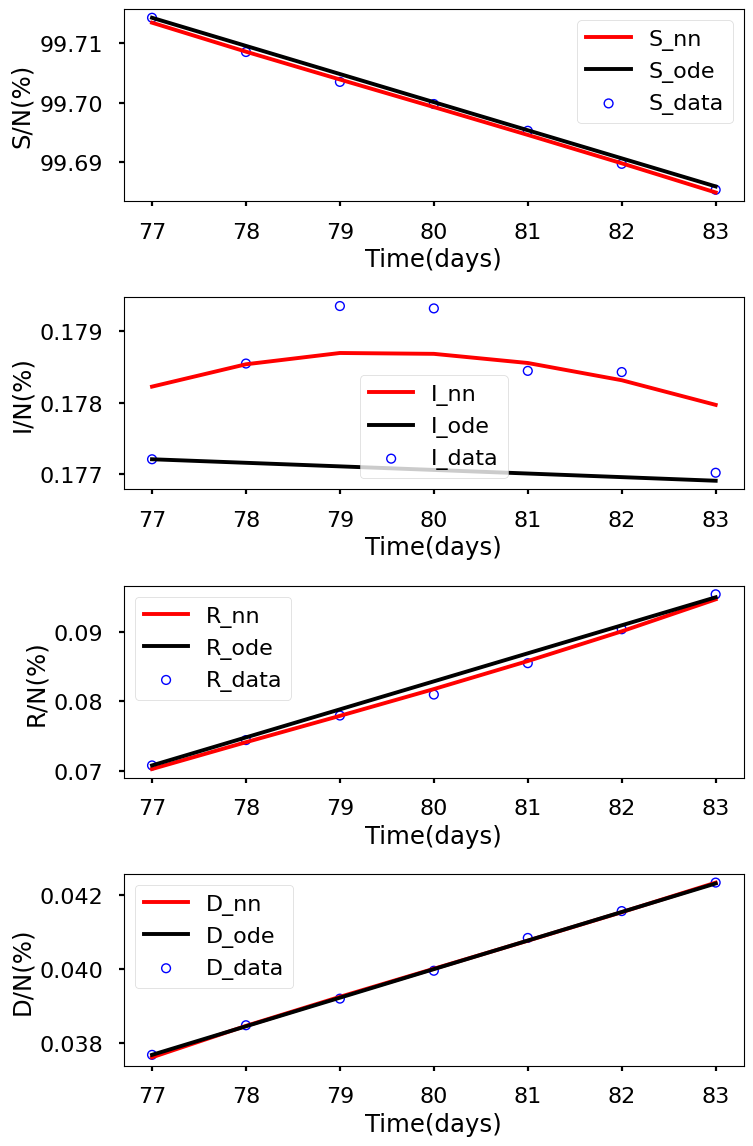

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

It: 0, Loss: 3.064e+00, GE_loss: 2.07656e+00,OB_loss: 9.86981e-01, Beta: 1.00000e+00,gamma: 9.99000e-01,mu: 9.99000e-01, Time: 3.72, cumulative_time: 3.72
It: 10000, Loss: 2.713e-06, GE_loss: 7.79132e-07,OB_loss: 1.93364e-06, Beta: 1.00000e+00,gamma: 9.60248e-01,mu: 9.60386e-01, Time: 32.33, cumulative_time: 36.05
It: 20000, Loss: 1.942e-06, GE_loss: 7.95901e-07,OB_loss: 1.14595e-06, Beta: 8.75031e-01,gamma: 6.53050e-01,mu: 6.45433e-01, Time: 28.88, cumulative_time: 64.93
It: 30000, Loss: 1.522e-10, GE_loss: 4.29565e-11,OB_loss: 1.09214e-10, Beta: 2.02963e-02,gamma: 2.17570e-02,mu: 3.36601e-03, Time: 29.10, cumulative_time: 94.02
It: 40000, Loss: 1.865e-10, GE_loss: 6.66762e-11,OB_loss: 1.19842e-10, Beta: 1.99536e-02,gamma: 2.15957e-02,mu: 3.29293e-03, Time: 29.83, cumulative_time: 123.85
beta:  [0.01985101]
gamma:  [0.02157457]
mu:  [0.00329861]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


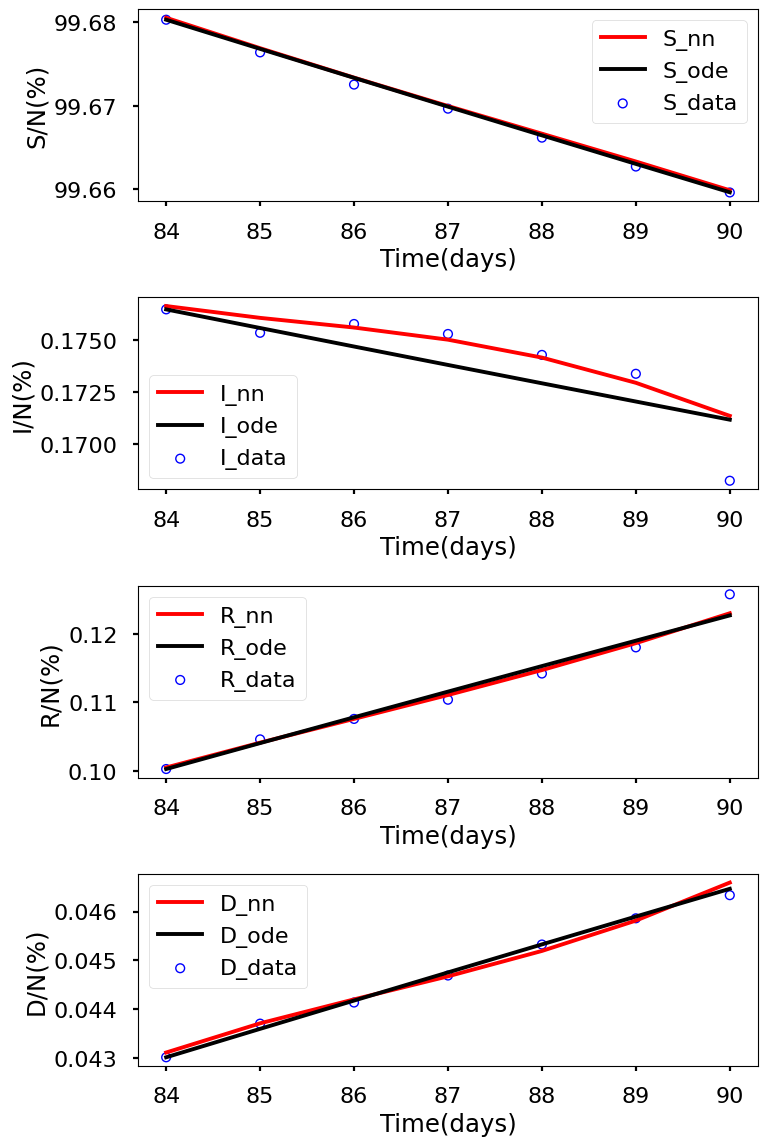

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

It: 0, Loss: 3.078e+00, GE_loss: 2.09316e+00,OB_loss: 9.84932e-01, Beta: 1.00000e+00,gamma: 9.99000e-01,mu: 9.99000e-01, Time: 3.70, cumulative_time: 3.70
It: 10000, Loss: 8.727e-07, GE_loss: 3.10587e-07,OB_loss: 5.62155e-07, Beta: 9.99403e-01,gamma: 9.59399e-01,mu: 9.59397e-01, Time: 63.14, cumulative_time: 66.84
It: 20000, Loss: 4.869e-07, GE_loss: 1.47086e-07,OB_loss: 3.39777e-07, Beta: 9.90575e-01,gamma: 9.23303e-01,mu: 9.21030e-01, Time: 66.06, cumulative_time: 132.90
It: 30000, Loss: 5.321e-10, GE_loss: 7.95142e-11,OB_loss: 4.52603e-10, Beta: 1.21567e-02,gamma: 3.63432e-02,mu: 2.99580e-03, Time: 67.19, cumulative_time: 200.09
It: 40000, Loss: 4.346e-10, GE_loss: 4.89219e-11,OB_loss: 3.85637e-10, Beta: 1.19865e-02,gamma: 3.64827e-02,mu: 2.63655e-03, Time: 64.44, cumulative_time: 264.53
beta:  [0.01197833]
gamma:  [0.03649848]
mu:  [0.00248762]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


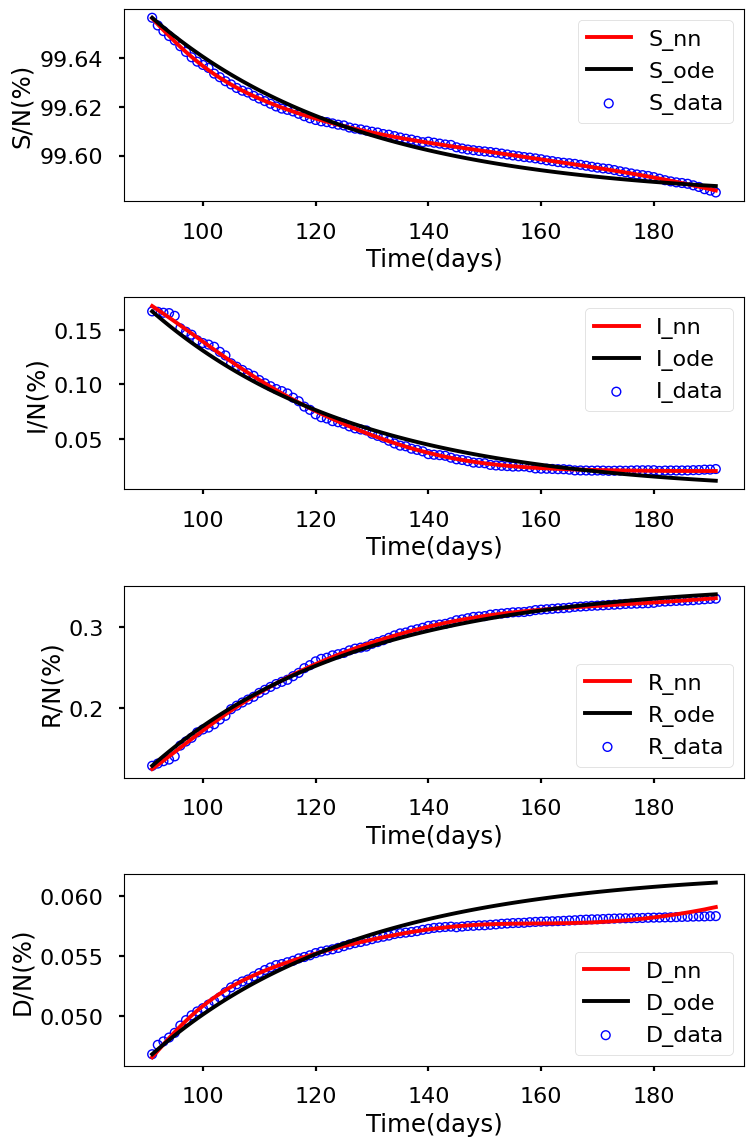

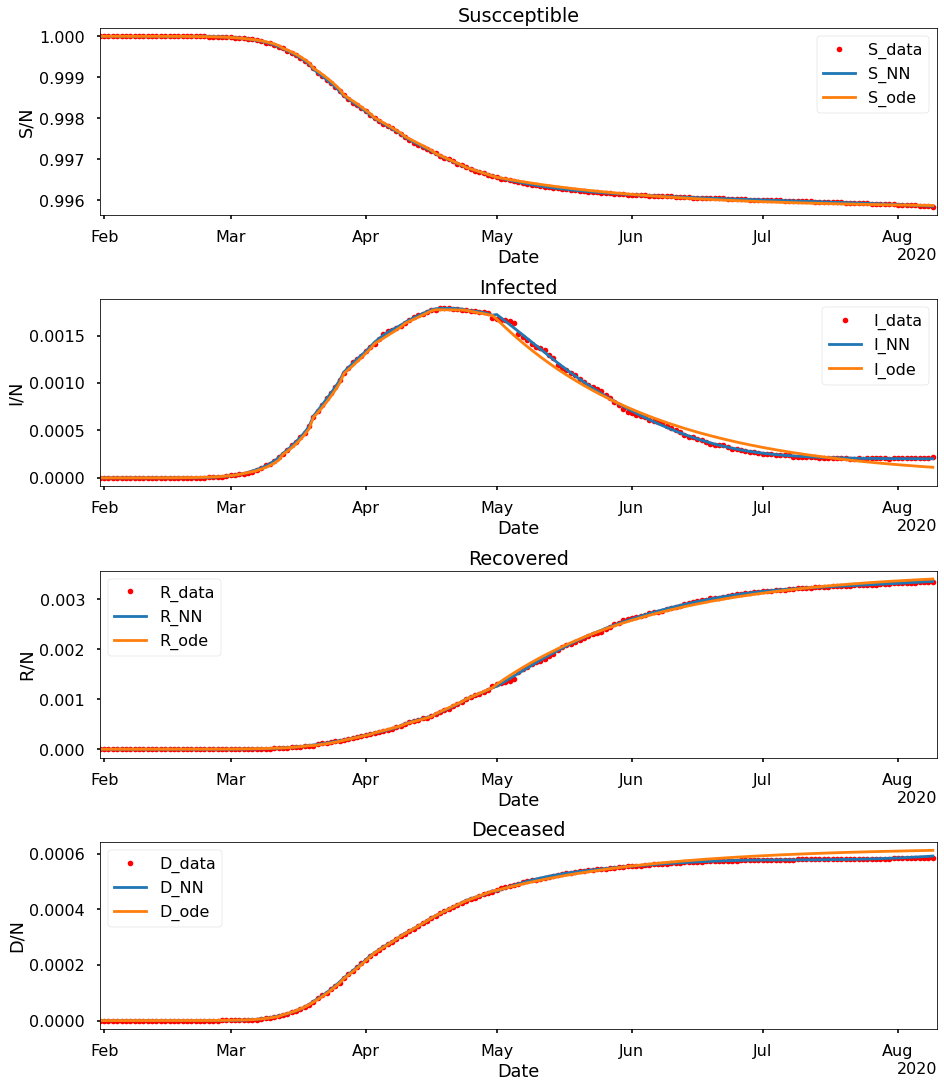

+---------------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|      Paramaters     | 01/31-03/05 | 03/06-03/12 | 03/13-03/19 | 03/20-03/26 | 03/27-04/02 | 04/03-04/09 | 04/10-04/16 | 04/17-04/23 | 04/24-04/30 | 05/02-08/09 |
+---------------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|         beta        |    0.2566   |    0.2143   |    0.1612   |    0.1062   |    0.0616   |    0.0415   |    0.0329   |    0.0269   |    0.0199   |    0.012    |
|        gamma        |    0.029    |    0.0228   |    0.0222   |    0.0176   |    0.0157   |    0.0154   |    0.0145   |    0.0228   |    0.0216   |    0.0365   |
|          mu         |    0.0107   |    0.017    |    0.0164   |    0.0142   |    0.0106   |    0.0066   |    0.0054   |    0.0044   |    0.0033   |    0.0025   |
| Reproduction N

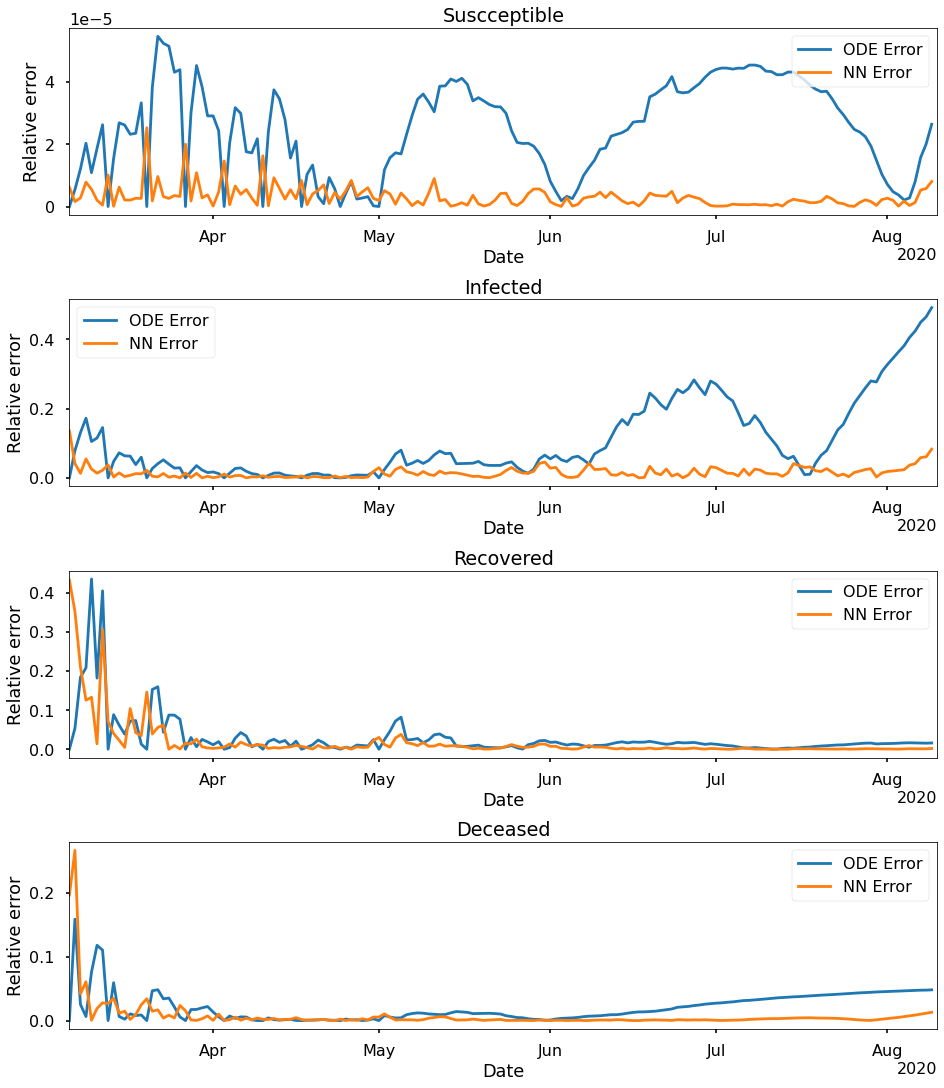

In [29]:
layers432 = [1,32,32,32,32,4]
S432_ode,I432_ode,R432_ode,D432_ode,S432_learned,I432_learned,R432_learned,D432_learned,beta432,gamma432,mu432,S_errnn432,I_errnn432,R_errnn432,D_errnn432,S_erode432,I_errode432,R_errode432,D_errode432,time432 = sum_all(
    layers432,length,SS,II,RC,DC,N0,0.1,50000)